### 序列数据
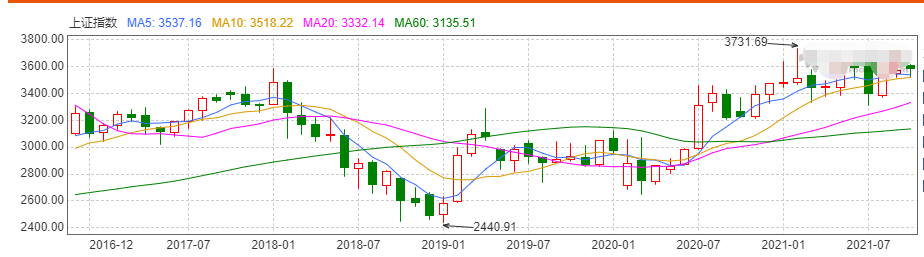

In [2]:
# 导包
import torch 
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
# d2l 
# 安装d2l
pip install d2l -i https://pypi.tuna.tsinghua.edu.cn/simple

In [7]:
from d2l import torch as d2l

In [8]:
d2l.plot??

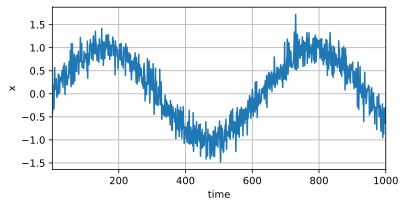

In [9]:
# 创建序列
# 创建1000个点
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# 创建正弦数据, 加上噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], xlabel='time', ylabel='x', xlim=[1, 1000], figsize=(6, 3))
# plt.plot(time, x)
# plt.xlabel('time')
# plt.ylabel('x')
# plt.xlim(1, 1000)
# plt.grid()

In [13]:
# X, y 自回归, X, y都是同一组序列数据, 只不过X是历史数据, y是将来数据.
tau = 4
features = torch.zeros((T - tau, tau))
# features.shape
# 对features每一列进行赋值
for i in range(tau):
    features[:, i] = x[i: T - tau + i ]
#     print(i, T - tau + i)
# 创建labels
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 生成dataset
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [14]:
for X, y in train_iter:
    print(X, y)
    print(X.shape, y.shape)
    break

tensor([[ 0.4646,  0.4348,  0.9413,  0.6532],
        [-0.2371, -0.0082, -0.0489,  0.2562],
        [ 0.5977,  0.5688,  0.6985,  0.6446],
        [-0.0316, -0.2349, -0.3791, -0.5025],
        [ 0.7632,  0.9548,  0.9351,  1.0045],
        [ 0.7371,  1.2228,  0.7010,  0.9675],
        [-0.2963, -0.6558, -0.4904, -0.3865],
        [-0.8457, -0.7189, -0.8119, -0.8257],
        [ 0.3584,  0.3410,  0.6863,  0.6994],
        [-0.7395, -0.7970, -1.2527, -0.6844],
        [ 0.6524,  0.2339,  0.5076,  0.7107],
        [-0.6906, -0.9549, -0.7995, -1.0752],
        [ 0.7686,  0.9459,  0.8712,  1.0941],
        [ 0.9967,  0.7686,  0.9459,  0.8712],
        [ 0.2394,  0.7628,  0.2060,  0.6524],
        [ 0.8662,  0.9664,  0.7705,  0.3965]]) tensor([[ 0.1543],
        [-0.1099],
        [ 0.6485],
        [-0.1386],
        [ 1.2666],
        [ 0.8811],
        [-0.9632],
        [-0.7183],
        [ 0.4646],
        [-0.4004],
        [ 0.1256],
        [-0.7497],
        [ 0.7544],
        [ 1.0941

In [12]:
d2l.load_array??

In [16]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 创建模型
# 创建一个简单的多层神经网络(感知机)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                       nn.ReLU(),
                       nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 定义损失
# mse 均方误差
loss = nn.MSELoss()

In [18]:
# 开始训练
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            # 梯度归零=
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}',
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss: 0.062547
epoch 2 loss: 0.054180
epoch 3 loss: 0.053983
epoch 4 loss: 0.051070
epoch 5 loss: 0.050659


In [17]:
d2l.evaluate_loss??

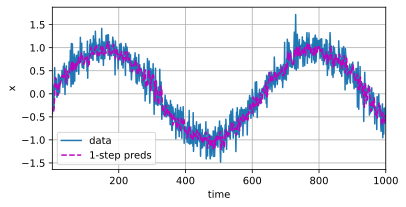

In [19]:
# 预测
onestep_preds = net(features)
# 预测结果和真实结果画在一起, 看一下预测的准不准. 
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

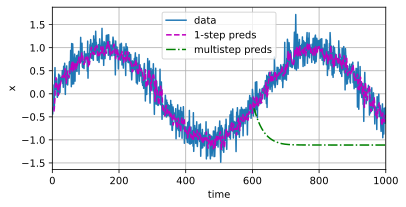

In [23]:
# 多步预测
multistep_preds = torch.zeros(T)
# 原始数据
multistep_preds[:n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau: i].reshape((1, -1)))
    
# 画图
d2l.plot([time, time[tau:], time[n_train + tau:]], 
        [x.detach().numpy(), onestep_preds.detach().numpy(),
         multistep_preds[n_train + tau:].detach().numpy()],
        'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
        xlim=[0, 1000], figsize=(6, 3))

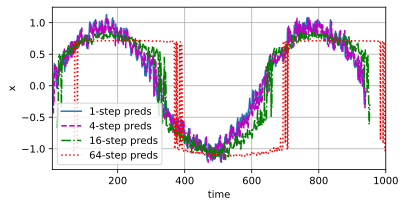

In [24]:
# 观察k步预测的结果
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 给前面tau列赋值
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    
# 再给后面tau 到 tau + max_steps列赋值
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape(-1)
    
# k步
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i -1 : T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6, 3))